# Incorporation of rat data to the DVC hierarchy

### Load packages/libraries

In [1]:
import os
os.chdir('../')
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import gdown
import copy as cp
import seaborn as sns
import pandas as pd
import anndata as ad
import pickle
from scipy.sparse import hstack, csc_matrix
from matplotlib import pyplot as plt
from scHPL.utils import TreeNode, _print_node, _count_nodes
import matplotlib.lines as mlines
import scanpy as sc
import torch

In [3]:
import scarches as sca
import scHPL
from scarches.dataset.trvae.data_handling import remove_sparsity

Global seed set to 0


#### Set other parameters

In [4]:
sc.settings.set_figure_params(dpi=1000, frameon=False)
sc.set_figure_params(dpi=1000)
sc.set_figure_params(figsize=(7,7))
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)
matplotlib.rcParams['pdf.fonttype'] = 42

### Import relevant data

In [5]:
#Full AnnData (Hes and Ludwig)
adata_full = sc.read('surgery_model_ludwig_2500/hesludwig_adata_processed_2500.h5ad')
adata_full

AnnData object with n_obs × n_vars = 171868 × 2500
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'ratio_nCount_nFeat', 'doubletfinder_class', 'seq_sample', 'treatment', 'single_r_celltypes', 'chen_celltypes', 'tasic_celltypes', 'romanov_celltypes', 'camp1_celltypes_full', 'identity_layer1', 'identity_layer2', 'identity_layer3', 'study', 'cellident_study', '_scvi_batch', '_scvi_labels', 'Unnamed: 0', 'percent.mito', 'percent.ribo', 'cell.type', 'neuronal.subtype', 'cell_barcode', 'ref_query1'
    var: 'mvp.mean-0', 'mvp.dispersion-0', 'mvp.dispersion.scaled-0', 'mvp.variable-0', 'highly_variable-0', 'means-0', 'dispersions-0', 'dispersions_norm-0', 'highly_variable_nbatches-0', 'highly_variable_intersection-0'
    layers: 'counts'

In [6]:
#Rat data
adata_rat = sc.read('DVC_datasets_2500/rat_Hes_database_2500.h5ad')
adata_rat

AnnData object with n_obs × n_vars = 12167 × 26081
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'ratio_nCount_nFeat', 'RNA_snn_res.0.2', 'RNA_snn_res.0.3', 'RNA_snn_res.0.5', 'RNA_snn_res.0.7', 'RNA_snn_res.1', 'RNA_snn_res.1.5', 'RNA_snn_res.2', 'RNA_snn_res.3', 'RNA_snn_res.4', 'seurat_clusters', 'pANN_0.25_0.12_974', 'doubletfinder_class', 'identity_layer1', 'identity_layer2', 'identity_layer3', 'cell_barcode'
    var: 'mvp.mean', 'mvp.dispersion', 'mvp.dispersion.scaled', 'mvp.variable'
    layers: 'counts'

### Prepare data

In [7]:
adata_rat.raw = adata_rat
adata_rat = adata_rat.copy()

In [8]:
#Normalize the rat dataset
sc.pp.normalize_total(adata_rat)

#Subset the rat dataset
adata_rat = adata_rat[:, adata_full.var_names]
adata_rat

View of AnnData object with n_obs × n_vars = 12167 × 2500
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'ratio_nCount_nFeat', 'RNA_snn_res.0.2', 'RNA_snn_res.0.3', 'RNA_snn_res.0.5', 'RNA_snn_res.0.7', 'RNA_snn_res.1', 'RNA_snn_res.1.5', 'RNA_snn_res.2', 'RNA_snn_res.3', 'RNA_snn_res.4', 'seurat_clusters', 'pANN_0.25_0.12_974', 'doubletfinder_class', 'identity_layer1', 'identity_layer2', 'identity_layer3', 'cell_barcode'
    var: 'mvp.mean', 'mvp.dispersion', 'mvp.dispersion.scaled', 'mvp.variable'
    layers: 'counts'

In [9]:
#Add the study variable
adata_rat.obs['study'] = 'rat_Hes'

In [10]:
#Ensure that the cell type labels of each dataset are unique
adata_rat.obs['cellident_study'] = np.char.add(np.char.add(np.array(adata_rat.obs['identity_layer3'],dtype= str), '_'),
                                                  np.array(adata_rat.obs['study'], dtype=str))

In [11]:
#Save the processed object
adata_rat.write('new_rat_Hes_database_2500.h5ad')

#### Build latent representation for the new query (the rat data)

In [12]:
full_path = 'full_model_2500/'

model = sca.models.SCVI.load_query_data(
    adata_rat,
    full_path,
    freeze_dropout = True,
)

INFO     File full_model_2500/model.pt already downloaded                                                          


In [13]:
model.train(max_epochs=50)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 50/50: 100%|███████████| 50/50 [01:17<00:00,  1.55s/it, loss=748, v_num=1]


In [14]:
query_latent = sc.AnnData(model.get_latent_representation())

In [15]:
query_latent.obs['orig.ident'] = adata_rat.obs['orig.ident'].tolist()
query_latent.obs['study'] = adata_rat.obs['study'].tolist()
query_latent.obs['cell_identity'] = adata_rat.obs['cellident_study'].tolist()

In [16]:
#Save this model
model.save('surgery_model_rat_2500/', overwrite=True)
query_latent.write('surgery_model_rat_2500/rat_latent_2500.h5ad')

### Update hierarchy with the rat data

In [17]:
adata_full_rodent = adata_full.concatenate(adata_rat, batch_key='ref_query2')
adata_full_rodent

AnnData object with n_obs × n_vars = 184035 × 2500
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'ratio_nCount_nFeat', 'doubletfinder_class', 'seq_sample', 'treatment', 'single_r_celltypes', 'chen_celltypes', 'tasic_celltypes', 'romanov_celltypes', 'camp1_celltypes_full', 'identity_layer1', 'identity_layer2', 'identity_layer3', 'study', 'cellident_study', '_scvi_batch', '_scvi_labels', 'Unnamed: 0', 'percent.mito', 'percent.ribo', 'cell.type', 'neuronal.subtype', 'cell_barcode', 'ref_query1', 'RNA_snn_res.0.2', 'RNA_snn_res.0.3', 'RNA_snn_res.0.5', 'RNA_snn_res.0.7', 'RNA_snn_res.1', 'RNA_snn_res.1.5', 'RNA_snn_res.2', 'RNA_snn_res.3', 'RNA_snn_res.4', 'seurat_clusters', 'pANN_0.25_0.12_974', 'ref_query2'
    var: 'mvp.mean-0-0', 'mvp.dispersion-0-0', 'mvp.dispersion.scaled-0-0', 'mvp.variable-0-0', 'highly_variable-0-0', 'means-0-0', 'dispersions-0-0', 'dispersions_norm-0-0', 'highly_variable_nbatches-0-0', 'highly_variable_intersection-0-0', 'mvp.mean-1', 'mvp.dispersion-1', '

In [18]:
#Save this object
adata_full_rodent.write('surgery_model_rat_2500/rodent_adata_processed_2500.h5ad')

#### Obtain latent representation

In [19]:
rodent_latent = sc.AnnData(model.get_latent_representation(adata=adata_full_rodent))

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


In [20]:
#Transfer variables to the latent representation
rodent_latent.obs['cell_identity'] = adata_full_rodent.obs['cellident_study'].tolist()
rodent_latent.obs['orig.ident'] = adata_full_rodent.obs['orig.ident'].tolist()
rodent_latent.obs['study'] = adata_full_rodent.obs['study'].tolist()
rodent_latent

AnnData object with n_obs × n_vars = 184035 × 10
    obs: 'cell_identity', 'orig.ident', 'study'

In [21]:
sc.pp.neighbors(rodent_latent)
sc.tl.leiden(rodent_latent)
sc.tl.umap(rodent_latent)

In [22]:
rodent_latent.obs['study'] = rodent_latent.obs['study'].astype('category')
rodent_latent.obs['study']

0             Hes
1             Hes
2             Hes
3             Hes
4             Hes
           ...   
184030    rat_Hes
184031    rat_Hes
184032    rat_Hes
184033    rat_Hes
184034    rat_Hes
Name: study, Length: 184035, dtype: category
Categories (3, object): ['Hes', 'ludwig', 'rat_Hes']

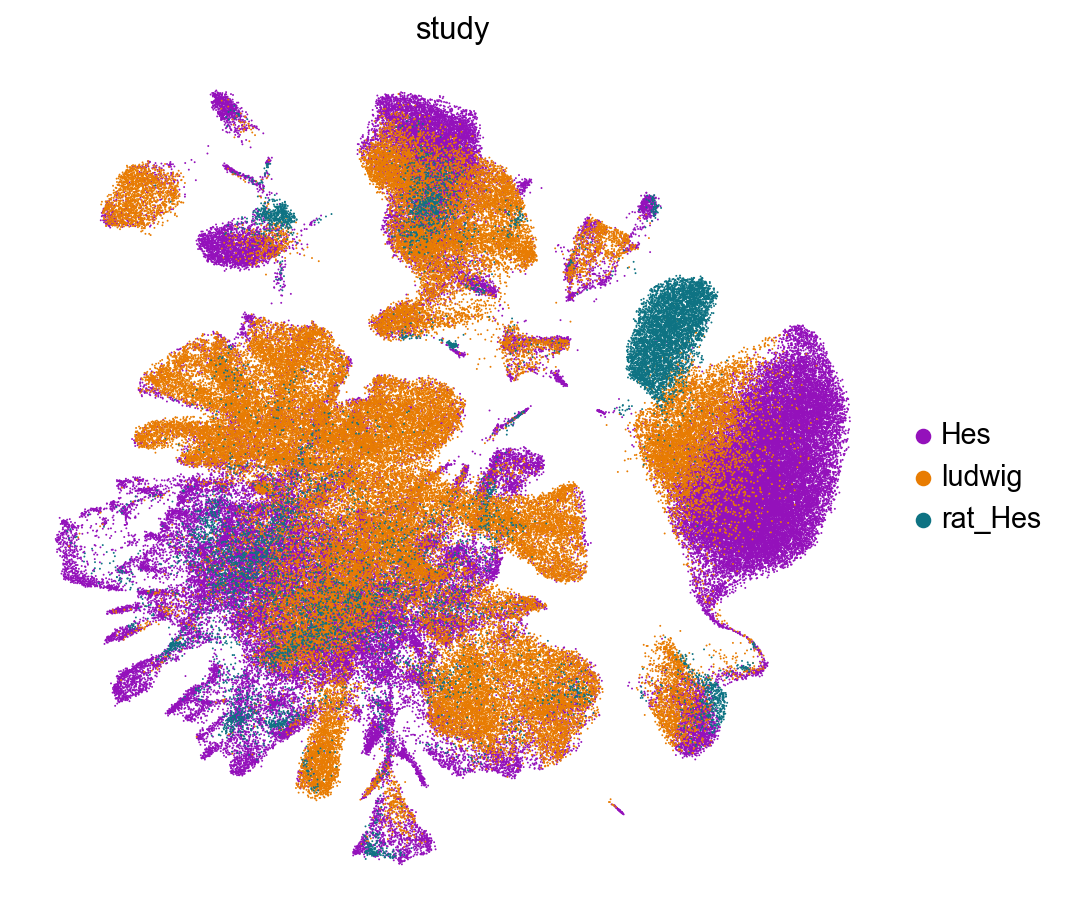

In [23]:
colors_umap =["#9411BB","#E87C02", "#0E7383"]

sc.pl.umap(rodent_latent,
           color=['study'],
           s=3,
           frameon=False,
           palette= colors_umap)

In [24]:
#Save latent representation and final model
model.save('full_rodent_model_2500/', overwrite=True)
rodent_latent.write('full_rodent_model_2500/full_rodent_latent_2500.h5ad')

#### Add the rat dataset to the hierarchy

In [25]:
#Upload the tree that contains Hes and Ludwig mouse data
file_to_read = open("full_model_2500/tree_full_HesLudwig_2500.pickle", "rb")
tree_rq = pickle.load(file_to_read)
file_to_read.close()

In [26]:
#Make a deep copy of the original classifier to ensure we do not overwrite it
tree_rodent = cp.deepcopy(tree_rq)

Starting tree:


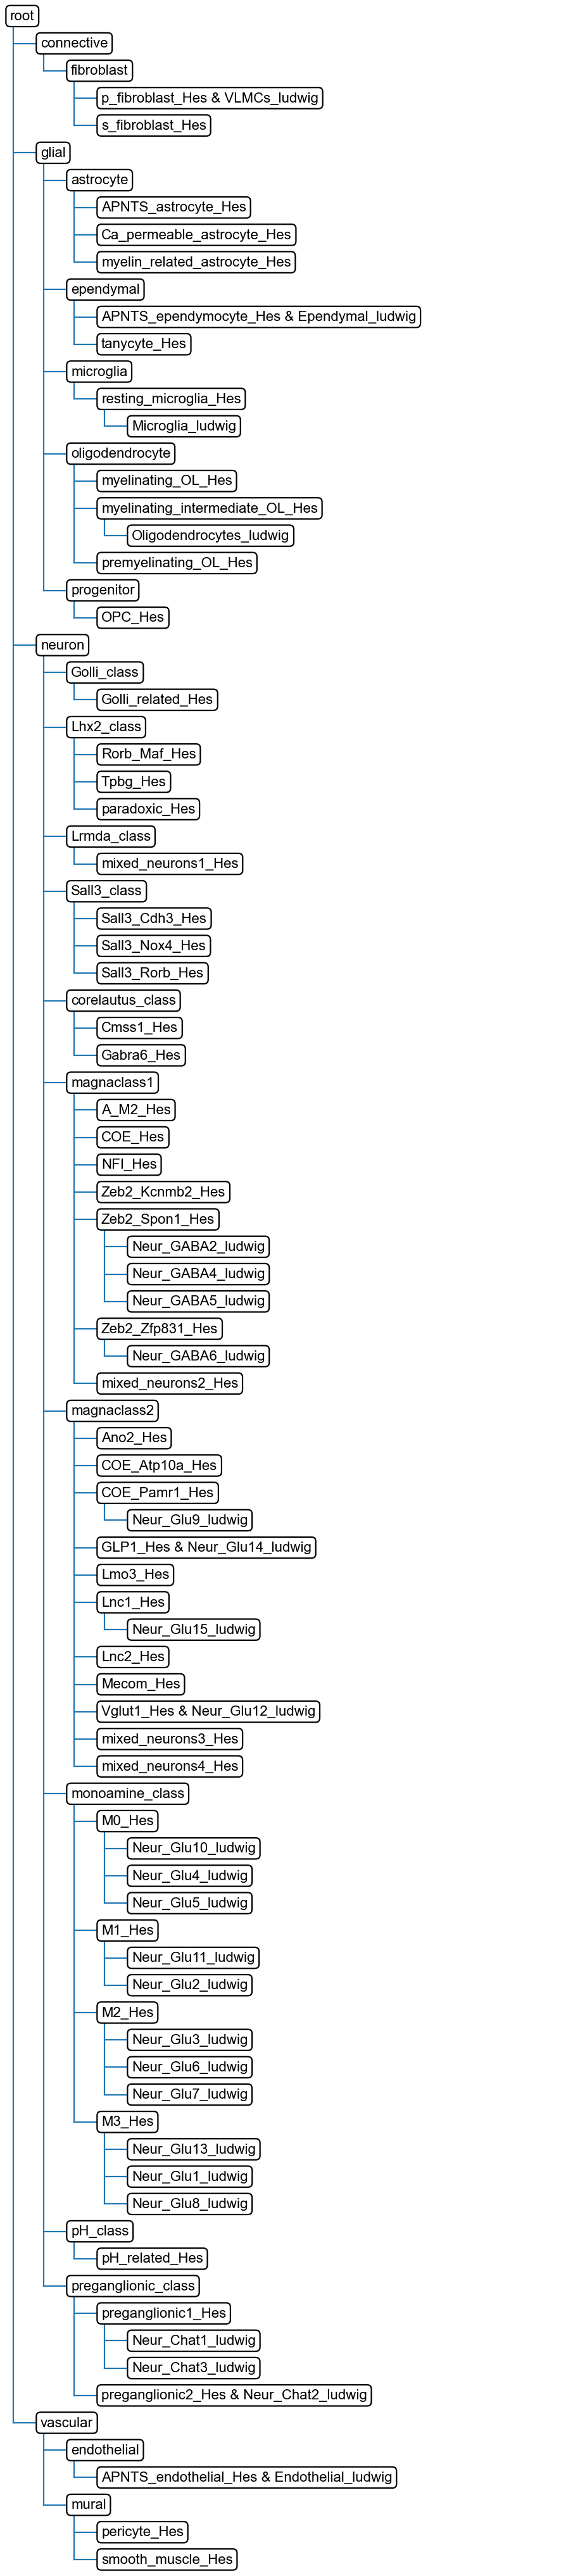


Adding dataset rat_Hes to the tree
Normalized CM
ypred                   APNTS_astrocyte_rat_Hes  APNTS_endothelial_rat_Hes  \
ytrue                                                                        
APNTS_astrocyte_Hes                    0.745527                   0.000000   
APNTS_endothelial_Hes                  0.000000                   0.208132   
APNTS_ependymocyte_Hes                 0.002716                   0.000000   
A_M2_Hes                               0.000000                   0.000000   
Ano2_Hes                               0.000000                   0.000000   
...                                         ...                        ...   
premyelinating_OL_Hes                  0.000000                   0.000000   
resting_microglia_Hes                  0.001794                   0.000000   
s_fibroblast_Hes                       0.000000                   0.000000   
smooth_muscle_Hes                      0.000000                   0.000000   
tanycyte_Hes  

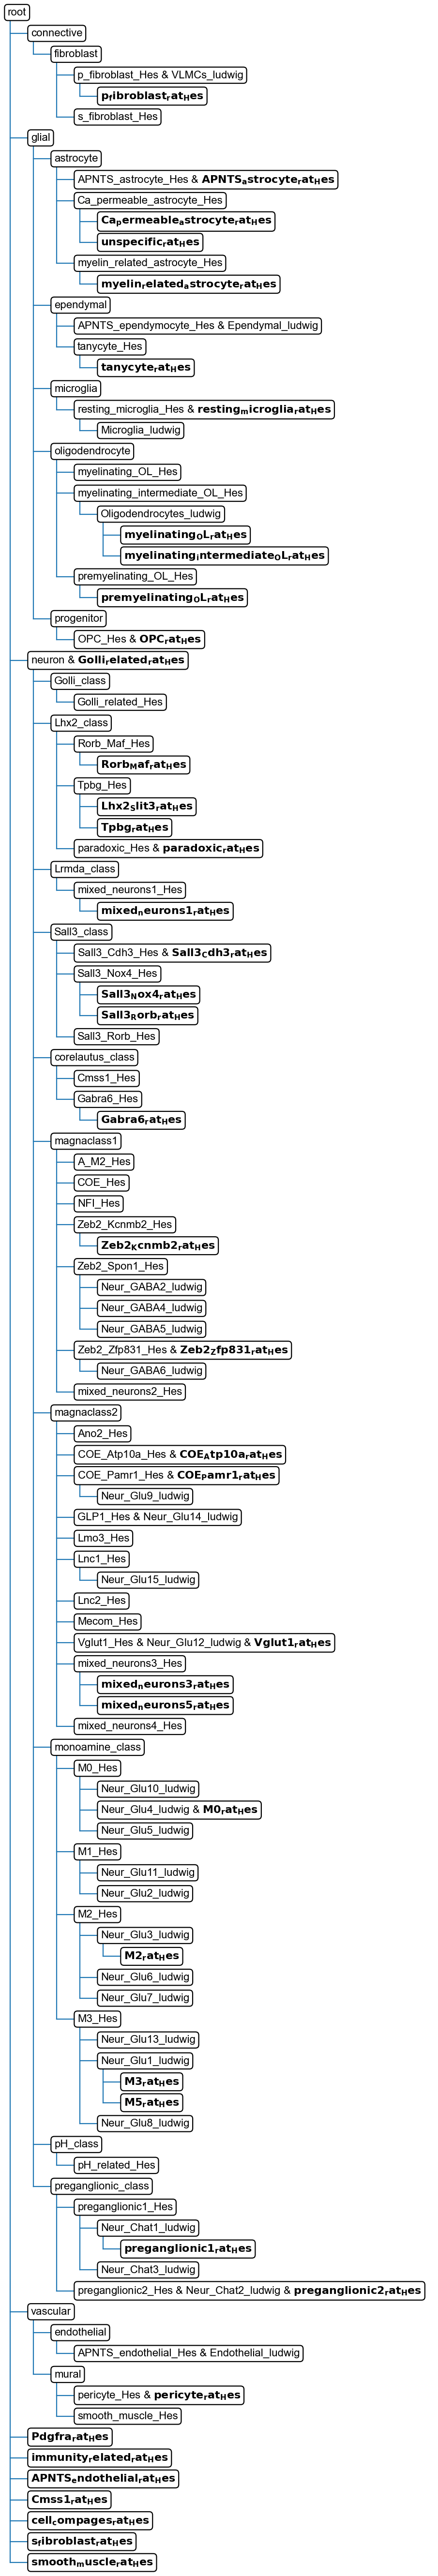

In [27]:
tree_rodent, mp_rodent = scHPL.learn_tree(data = rodent_latent, 
                                  batch_key = 'study',
                                  batch_order = ['rat_Hes'],
                                  batch_added = ['Hes', 'ludwig'],
                                  cell_type_key= 'cell_identity',
                                  tree = tree_rodent, 
                                  retrain = False,
                                  useRE=True,
                                  classifier = 'knn',
                                  dimred = False,
                                 print_conf=True)

In [28]:
##Save the tree
file_to_store = open('full_rodent_model_2500/tree_full_rodent_2500.pickle', 'wb')
pickle.dump(tree_rodent, file_to_store)
file_to_store.close()

### Curate hierarchy

In [29]:
#Make another deep copy of the rodent classifier to ensure we do not overwrite it
tree_rodent_mod = cp.deepcopy(tree_rodent)

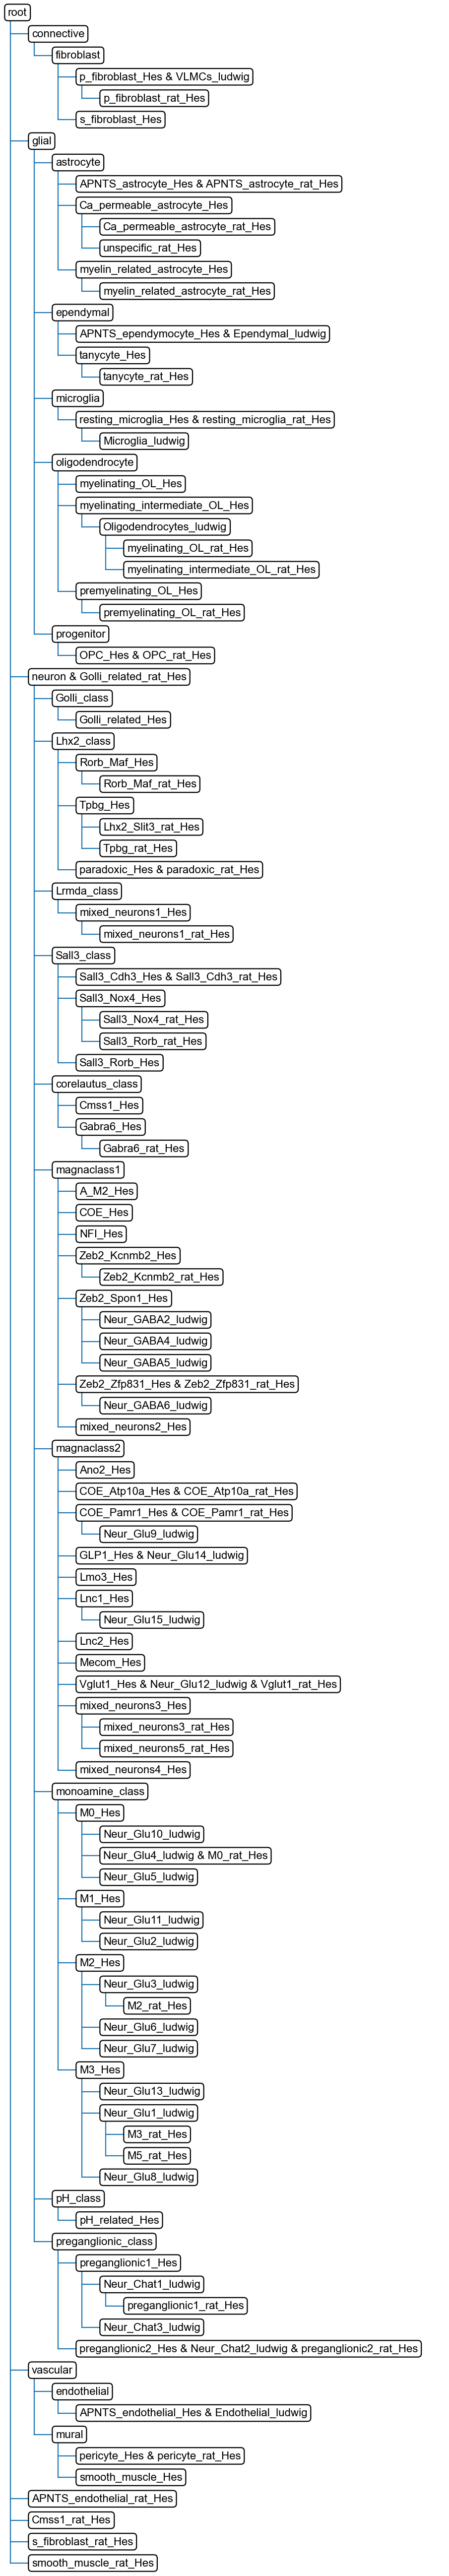

In [30]:
#Some new cell identities were noted from the manual label assignation to the rat dataset: Pdgfra, immunity-related and cell-compages
##These and their classes will be added and moved to the tree below the 'neuron' parent node (they have to be removed from where they are)
tree_rodent_mod= scHPL.utils.remove_node(name= 'Pdgfra_rat_Hes', tree= tree_rodent_mod, children= False)
tree_rodent_mod= scHPL.utils.remove_node(name= 'cell_compages_rat_Hes', tree= tree_rodent_mod, children= False)
tree_rodent_mod= scHPL.utils.remove_node(name= 'immunity_related_rat_Hes', tree= tree_rodent_mod, children= False)

scHPL.utils.print_tree(tree_rodent_mod)

Tree after fixing new neuron types nodes:


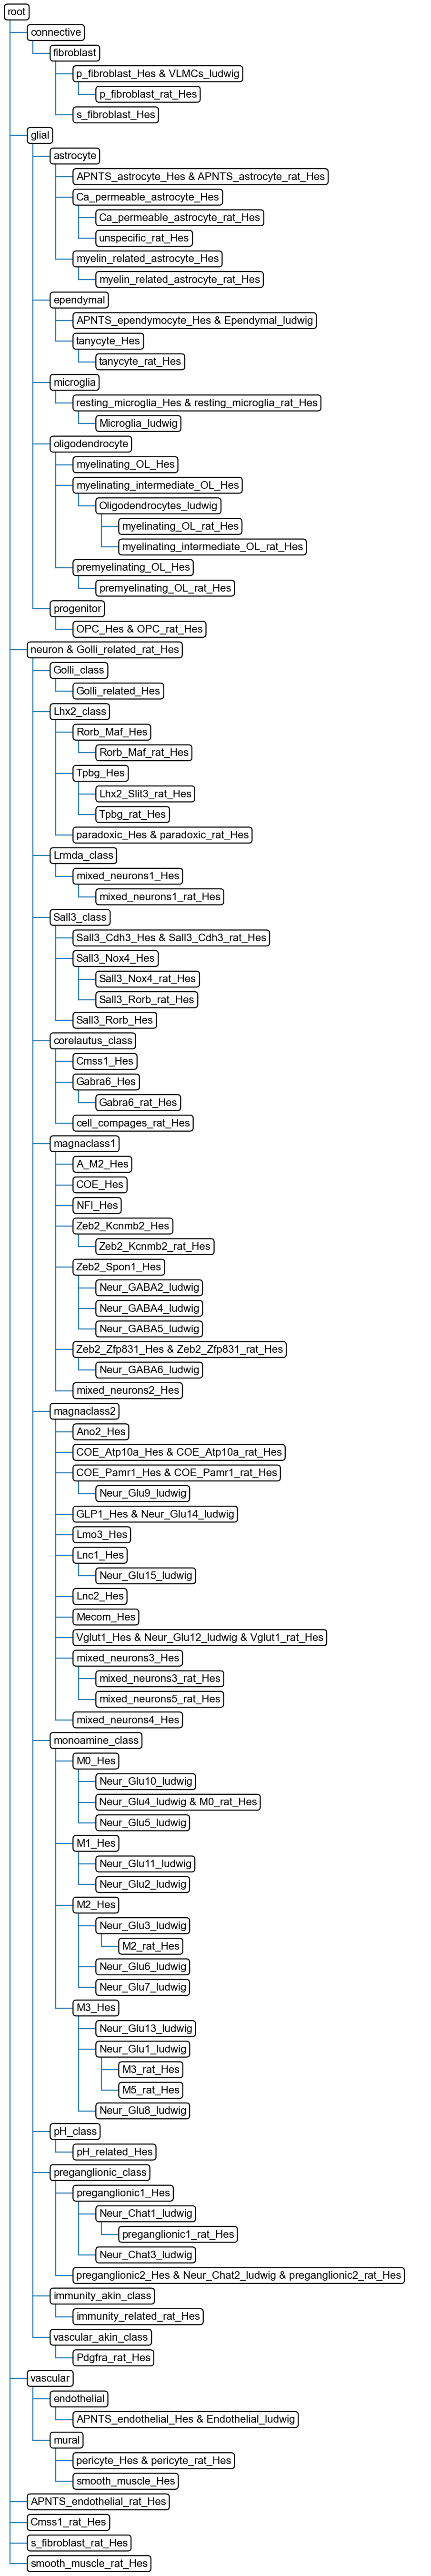

In [31]:
tree_rodent_mod= scHPL.utils.add_node(name= 'cell_compages_rat_Hes', tree= tree_rodent_mod, parent= 'corelautus_class', children=False)

tree_rodent_mod= scHPL.utils.add_node(name= 'immunity_akin_class', tree= tree_rodent_mod, parent= 'neuron', children=False)
tree_rodent_mod= scHPL.utils.add_node(name= 'immunity_related_rat_Hes', tree= tree_rodent_mod, parent= 'immunity_akin_class', children=False)

tree_rodent_mod= scHPL.utils.add_node(name= 'vascular_akin_class', tree= tree_rodent_mod, parent= 'neuron', children=False)
tree_rodent_mod= scHPL.utils.add_node(name= 'Pdgfra_rat_Hes', tree= tree_rodent_mod, parent= 'vascular_akin_class', children=False)


print('Tree after fixing new neuron types nodes:')
scHPL.utils.print_tree(tree_rodent_mod)

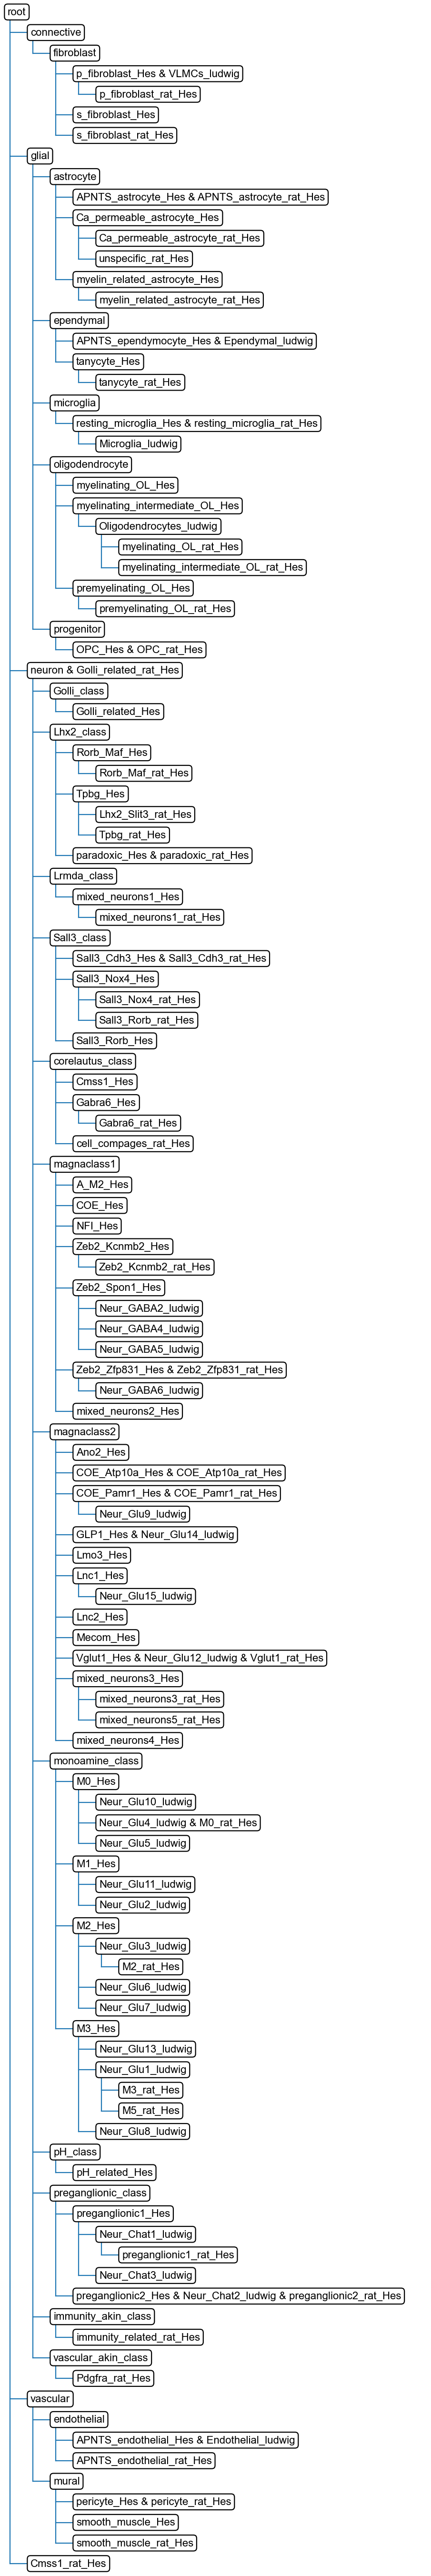

In [32]:
#Some cell identities have specific transcritptional programs in the rat and proved to be the assigned identity: Golli-related, endothelial, s-fibroblasts and smc
##Their scores were tracked and they do share most similarity with the equivalent mice cells but not enough for treeArches to assign them
##They will be moved to the same layer as the mice cells, therefore
tree_rodent_mod= scHPL.utils.remove_node(name= 'APNTS_endothelial_rat_Hes', tree= tree_rodent_mod, children= False)
tree_rodent_mod= scHPL.utils.remove_node(name= 's_fibroblast_rat_Hes', tree= tree_rodent_mod, children= False)
tree_rodent_mod= scHPL.utils.remove_node(name= 'smooth_muscle_rat_Hes', tree= tree_rodent_mod, children= False)

tree_rodent_mod= scHPL.utils.add_node(name= 'APNTS_endothelial_rat_Hes', tree= tree_rodent_mod, parent= 'endothelial', children=False)
tree_rodent_mod= scHPL.utils.add_node(name= 's_fibroblast_rat_Hes', tree= tree_rodent_mod, parent= 'fibroblast', children=False)
tree_rodent_mod= scHPL.utils.add_node(name= 'smooth_muscle_rat_Hes', tree= tree_rodent_mod, parent= 'mural', children=False)

scHPL.utils.print_tree(tree_rodent_mod)

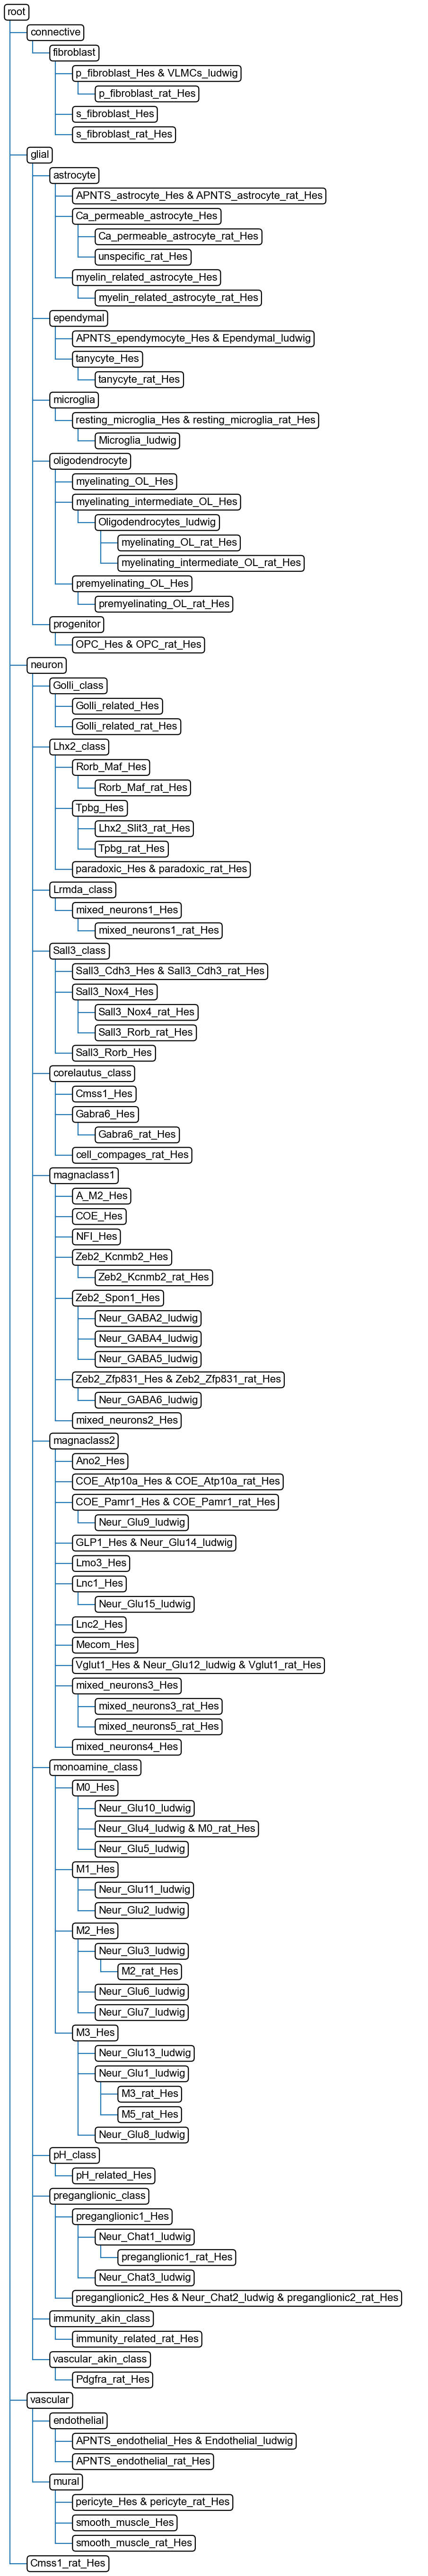

In [33]:
tree_rodent_mod= scHPL.utils.rename_node(old_name = 'Golli_related_rat_Hes', new_name = 'neuron', tree = tree_rodent_mod)
tree_rodent_mod= scHPL.utils.add_node(name= 'Golli_related_rat_Hes', tree= tree_rodent_mod, parent= 'Golli_class', children=False)

scHPL.utils.print_tree(tree_rodent_mod)

Tree after fixing all nodes:


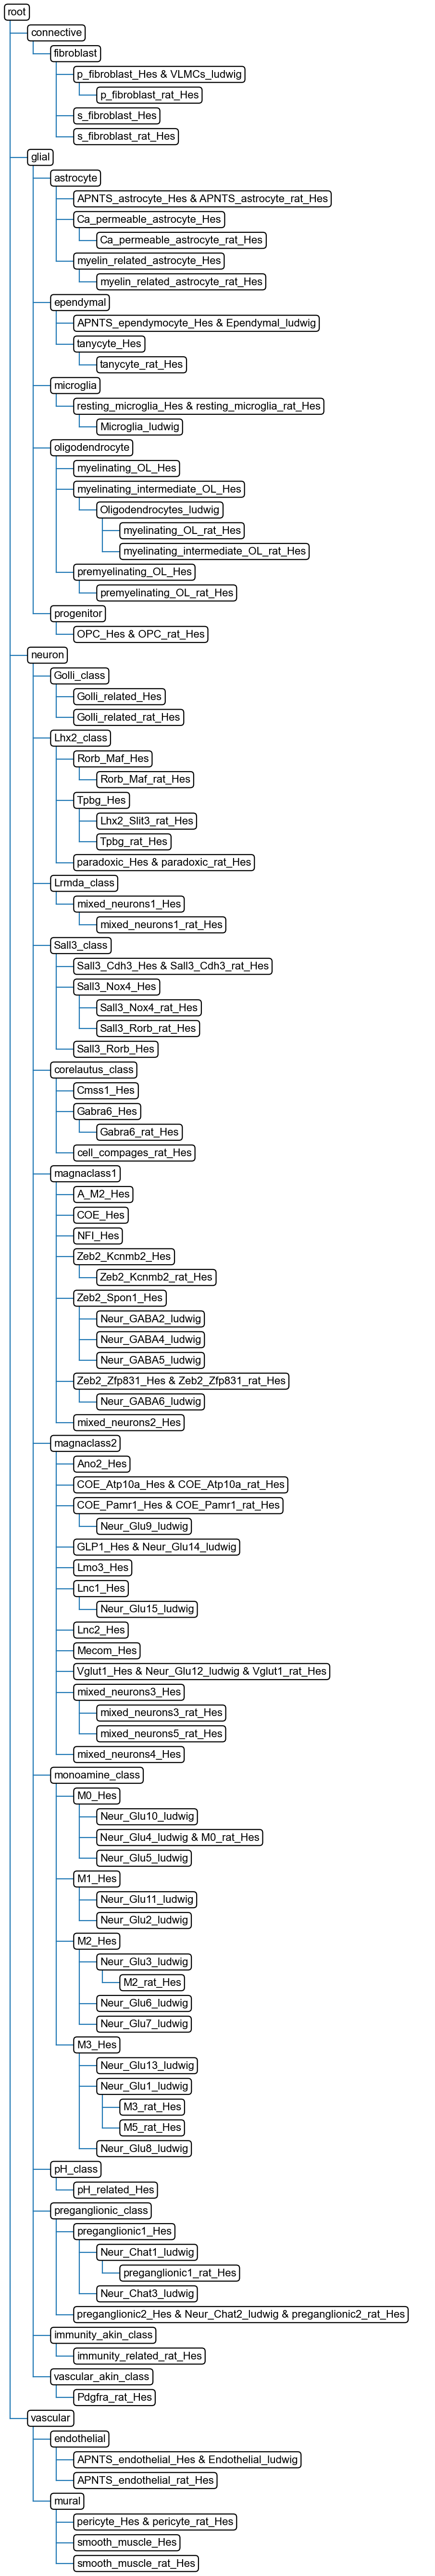

In [34]:
#On the other hand, the rat Cmss1 were not found to be similar to the mice Cmss1 and may be an artifact, therefore the node will be removed
##The unspecific cells also do not seem to display the most important astrocyte markers despite simmilarity in treeArches
tree_rodent_mod= scHPL.utils.remove_node(name='Cmss1_rat_Hes', tree= tree_rodent_mod, children= False)
tree_rodent_mod= scHPL.utils.remove_node(name='unspecific_rat_Hes', tree= tree_rodent_mod, children= False)

print('Tree after fixing all nodes:')
scHPL.utils.print_tree(tree_rodent_mod)

#### Retrain tree

In [35]:
tree_rodent_mod = scHPL.train.train_tree(rodent_latent.X, 
                                   np.array(rodent_latent.obs.cell_identity.values), 
                                   tree_rodent_mod, 
                                   classifier = 'knn', 
                                   dimred = False, 
                                   useRE = True, 
                                   FN = 0.5, 
                                   n_neighbors = 50, 
                                  dynamic_neighbors = True)

#### Final tree

Final retrained tree:


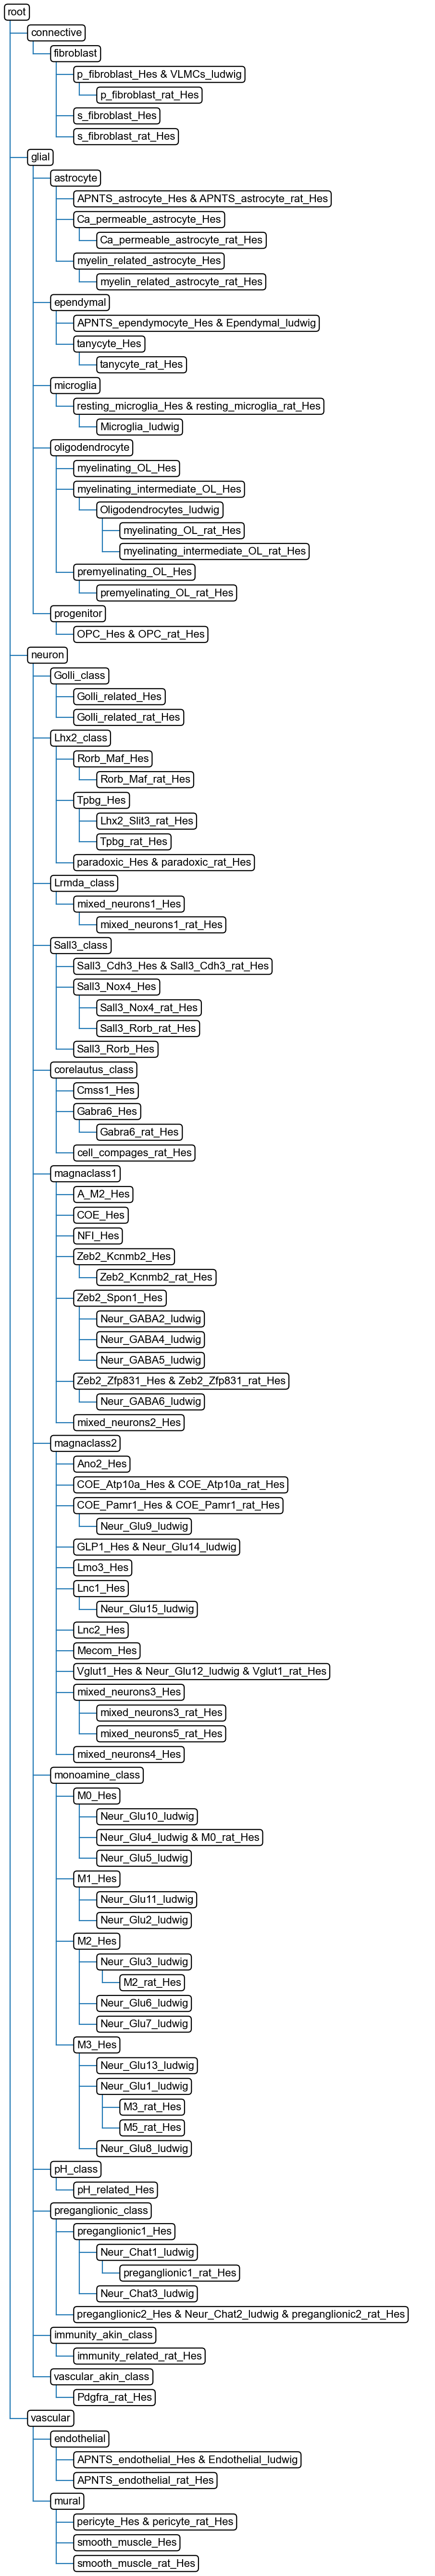

In [36]:
print('Final retrained tree:')
scHPL.utils.print_tree(tree_rodent_mod)

In [37]:
##Save the tree
file_to_store = open('full_rodent_model_2500/correct_tree_full_rodent_2500.pickle', 'wb')
pickle.dump(tree_rodent_mod, file_to_store)
file_to_store.close()